<a href="https://colab.research.google.com/github/AlvaroUriel/idal_ia3/blob/main/TareaNLP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('sem_eval_train_es.csv')
#df_train = pd.read_csv('sem_eval_test_blank_es.csv')
df_train.head()


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False


In [3]:
df_train.count()

ID              3561
Tweet           3561
anger           3561
anticipation    3561
disgust         3561
fear            3561
joy             3561
love            3561
optimism        3561
pessimism       3561
sadness         3561
surprise        3561
trust           3561
dtype: int64

In [4]:
df_train.iloc[16].Tweet

'Que bien se siente pelear de nuevo, aunque esté bien tronco '

Vemos como es la distribución de etiquetas


In [5]:
print(df_train.anger.value_counts()[1])
print(df_train.anticipation.value_counts()[1])
print(df_train.disgust.value_counts()[1])
print(df_train.fear.value_counts()[1])
print(df_train.joy.value_counts()[1])
print(df_train.optimism.value_counts()[1])
print(df_train.pessimism.value_counts()[1])
print(df_train.sadness.value_counts()[1])
print(df_train.surprise.value_counts()[1])
print(df_train.trust.value_counts()[1])

1155
415
521
373
1087
378
578
845
169
175


In [6]:
df_train['pre_clean_len'] = df_train.Tweet.str.len()
df_train.pre_clean_len.describe()

count    3561.000000
mean       77.048301
std        35.753085
min         9.000000
25%        47.000000
50%        73.000000
75%       106.000000
max       140.000000
Name: pre_clean_len, dtype: float64

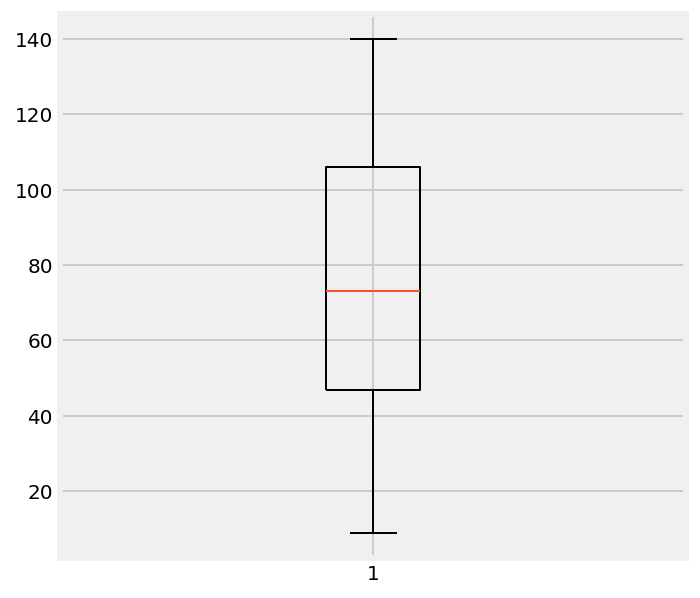

In [7]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df_train.pre_clean_len)
plt.show()

## Limpieza de texto
Hacemos un pequeño pre-procesado del texto antes de extraer las características:  
- Quitamos las menciones y las URL del texto porque no aportan valor para el análisis de sentimientos.
- Los hashtag sí que pueden aportar valor así que simplemente quitamos el #.
- Quitamos los signos de puntuación y palabras menores de 3 caracteres.
- Por último quitamos todos los símbolos de puntuación del texto (que forman parte de un token).
- Lematizamos el texto y lo guardamos en otra columna para comparar resultados del clasificador.

In [8]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!python -m spacy download es_core_news_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.3 MB 83 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [10]:
import re, string, spacy
nlp=spacy.load('es_core_news_md')

In [11]:
#lista de stop-words específicos de nuestro corpus (aproximación)
stop_words = ['unos', 'unas', 'algún', 'alguna', 'algunos', 'algunas', 'ese', 'eso', 'así']

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, lemas=False):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Si lemas=True extraemos el lema, si no dejamos en minúsculas solamente.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[\w_]+', 'MENCION', text) #elimina menciones y URL
    #text = re.sub(r'|https?://[\w_./]+', 'URL', text) #elimina menciones y URL
    text = re.sub(r'\S*https?:\S*', "URL", text)

    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens if not (tok in stop_words) and len(tok)>2]
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text
    

In [12]:
print('Original:\n',df_train.Tweet[16])
print('\nLimpiado:\n',clean_text(df_train.Tweet[16]))
print('\nLematizado:\n',clean_text(df_train.Tweet[16], lemas=True))

Original:
 Que bien se siente pelear de nuevo, aunque esté bien tronco 

Limpiado:
 que bien siente pelear nuevo aunque esté bien tronco

Lematizado:
 que bien sentir pelear nuevo aunque estar bien tronco


In [13]:
df_train[df_train.Tweet.str.contains('http')]


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,pre_clean_len
1058,2018-Es-04461,¡Gran susto en la casa de #MOParaguay!😱 ¿Ña Su...,False,False,False,True,False,False,False,False,False,False,False,140


In [15]:
df_train["limpio"]=df_train['Tweet'].apply(clean_text)

In [16]:
#Quitamos tweets vacíos después de la limpieza
df_train=df_train[df_train.limpio!='']

In [19]:
df_train['lemas'] = df_train['Tweet'].apply(clean_text, lemas=True)

In [20]:
df_train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,pre_clean_len,limpio,lemas
0,2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False,78,mencion ajajjaa somos del clan twitteras perdi...,mencion ajajjaa ser del clan twittera perdido ...
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False,64,mencion mala suerte del gato fichame cara help...,mencion malo suerte del gato fichame cara help...
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False,100,mencion tampoco agrado mucho especialmente por...,mencion tampoco agradar mucho especialmente po...
3,2018-Es-00208,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False,132,para llevar los bebes lugar otro debemos canta...,para llevar beb uno lugar otro deber cantar él...
4,2018-Es-01385,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False,139,mencion encanta terrible hipocresia doble mora...,mencion encantar terrible hipocresia doble mor...
